## Task 2 - Implement Word2vec 25 Marks
You are tasked with building a pipeline for training a Word2Vec model using the CBOW (Continuous Bag
of Words) approach FROM SCRATCH in PyTorch. It consist of the following components:

1. You are required to create a Python class named Word2VecDataset that will serve as a custom dataset
for training the Word2Vec model. The implementaion should include the following components:

    - The custom implementation should work with PyTorch’s DataLoader to efficiently load the train-
ing data.. You can refer this guide [Tutorial] on creating custom dataset classes in PyTroch.

    - preprocess data - In this method, you will be preprocessing the provided corpus and prepare
the CBOW training data for training the Word2Vec model.

    - During preprocessing, you must use the WordPieceTokenizer implemented in Task 1 to tokenize
the input text corpus.

2. You required to create a Python class named Word2VecModel which implement Word2Vec CBOW
architecture from scratch using PyTorch. After training the the model, save the trained model’s
checkpoint for later use.

3. Develop a function named train to manage the entire training process of the Word2Vec model. This
function should include all the training logic.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json
import os
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm

import sys
import os


In [3]:
sys.path.append(os.path.abspath('../Task 1'))

print(os.getcwd())

# changing directories to get the WordPieceTokenizer class from task1
os.chdir('../Task1')

print(os.getcwd())

from task1 import WordPieceTokenizer

tokenizer = WordPieceTokenizer()

os.chdir('../Task2')

print(os.getcwd())


c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\CSE556-NLP\assignment1\Task2
c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\CSE556-NLP\assignment1\Task1
c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\CSE556-NLP\assignment1\Task2


## Word2VecDataset Class

In [4]:
# Word2VecDataset(Dataset) => inherits from the Dataset class of Pytorch
class Word2VecDataset(Dataset):
    
    def __init__(self, window_size, vocabulary_size):
        
        """
        text : input corput as string
        window size : defines how many words to take on either side as context
        pad token : a special token used for padding in case of insufficient context
        """

        self.pad_token = '[PAD]'
        self.window_size = window_size
        self.tokenizer = WordPieceTokenizer()
        self.vocabulary_size = vocabulary_size

        self.text = None

        # stores unique words in the corpus
        self.vocabulary = None
        # a dictionary mapping words to indices
        self.word_to_idx = None
        # a dictionary mapping indices to words
        self.idx_to_word = None
        # a list that will store training pairs
        self.cbow_pairs = []
        
        self.preprocess_data()

    # uses Word Piece Tokenizer from Task 1 to tokenize input corpus
    def tokenize_txt_file(self, input_file, output_file):
        
        with open(input_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        results = {}
        
        for idx, line in enumerate(lines):
            sentence = line.strip() 
            tokens = self.tokenizer.tokenize(sentence)
            results[str(idx)] = tokens 

        
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2)

    

    def update_vocabulary(self):

        self.tokenizer.construct_vocabulary("corpus.txt", vocab_size=self.vocabulary_size)

        vocabulary = []

        # Open the file in read mode
        with open('vocabulary_35.txt', 'r') as file:
            
            for line in file:
                word = line.strip()
                if word:  # to avoid adding empty lines
                    vocabulary.append(word)

        self.vocabulary = vocabulary
        print("got and updated vocab")

    
    def tokenize_corpus(self):
        
        self.tokenize_txt_file("corpus.txt", "tokenized_corpus.json")

        corpus = None

        with open('tokenized_corpus.json', 'r', encoding='utf-8') as f:

            # Load the JSON data
            tokenized_corpus = json.load(f)
            
            # Convert the dictionary into a list of sentences (list of tokenized words)
            corpus = [tokens for tokens in tokenized_corpus.values()]
            
        
        self.text = corpus


    def generate_cbow_pairs(self):

        # loops over all the  in the tokenized corpus
        for sentence in self.text:

            for j in range(len(sentence)):
                # Get context words within window
                context_words = (sentence[max(0, j - self.window_size):j] + 
                                sentence[j + 1:min(len(sentence), j + self.window_size + 1)])
                
                if len(context_words) > 0:
                    # Pad context if necessary
                    while len(context_words) < self.window_size * 2:
                        context_words.append(self.pad_token)
                    
                    # Convert context words and target words into numerical indices using self.word2idx
                    context_indices = [self.word_to_idx.get(w, self.word_to_idx[self.pad_token]) for w in context_words]
                    target_idx = self.word_to_idx.get(sentence[j], self.word_to_idx[self.pad_token])
                    
                    # Store the (context, target) pairs in self.cbow_pairs
                    self.cbow_pairs.append((context_indices, target_idx))


    # this function tokenizes text, creates the vocabulary and generates CBOW training pairs
    def preprocess_data(self):

        print("updating vocabulary")     
        self.update_vocabulary()

        print("tokenizing corpus")
        self.tokenize_corpus()

        print("updating mapping - word2idx and idx2word")

        # updates the word to index mapping
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocabulary)}
        # updates the reverse index to word mapping
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        

        print("generating cbow pairs")
        self.generate_cbow_pairs()
    
    # returns the total number of CBOW training pairs
    def __len__(self):
        return len(self.cbow_pairs)
    
    
    # used to retrieve a single CBOW pair (context, target) pair
    def __getitem__(self, idx):

        # get the pair of ith index as mentioned parameter 
        context_indices, target_idx = self.cbow_pairs[idx]
        
        # Convert to tensors with explicit types
        context_tensor = torch.tensor(context_indices, dtype=torch.long)
        target_tensor = torch.tensor(target_idx, dtype=torch.long)
        
        return context_tensor, target_tensor


## Word2VecModel class

In [5]:
# Word2VecModel(nn.Module) => Inherits from nn.Module class in Pytorch
class Word2VecModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        
        '''
        vocab size : the size of the vocabulary
        embedding dimension : the number of features that represent each word
        '''

        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # creates a special table that stores word representations for each word
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        

        self._initialize_weights()
    
    # function to initialize weight
    def _initialize_weights(self):
        
        # range of weights
        initrange = 0.5 / self.embedding_dim
        
        # initializing embedding layer
        self.embeddings.weight.data.uniform_(-initrange, initrange)
        
        # initializing output layer
        self.output_layer.weight.data.uniform_(-initrange, initrange)

        # initializing the bias of output layer
        self.output_layer.bias.data.zero_()
    

    # function for forward pass of the model
    def forward(self, x: torch.Tensor):

        """
        x : input tensor, which represents the indices of the context words in the vocabulary. Its shape is [batch size, window size*2] -- [target word, [list of indexes of context words]]
        """

        # will look up for embeddings for each word in context and output list of embeddings of each congext word
        # size = [batch size, window size*2, embedding dimension]
        embedded = self.embeddings(x)
        
        # calculates average of context words... horizontally - row by row
        # size = [batch_size, embedding_dim]
        context_embedding = torch.mean(embedded, dim=1)
        
        # passing the average context embedding to output layer
        # output size vector = [batch_size, vocab_size]
        output = self.output_layer(context_embedding)

        # returning after application of softmax function
        return F.log_softmax(output, dim=1)

    def get_word_vector(self, word_idx: int) -> torch.Tensor:
        """
        Get the embedding vector for a given word index
        """
        return self.embeddings.weight.data[word_idx]
    
    def cosine_similarity(self, word_idx1: int, word_idx2: int) -> float:
        """
        Calculate cosine similarity between two word vectors
        """
        vec1 = self.get_word_vector(word_idx1)
        vec2 = self.get_word_vector(word_idx2)
        
        return F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()
    
    def find_most_similar(self, word_idx: int, top_k: int = 2) -> list:
        """
        Find the top_k most similar words to the given word
        Returns: list of tuples (word_idx, similarity_score)
        """
        target_vector = self.get_word_vector(word_idx)
        
        # Calculate similarities with all words
        similarities = F.cosine_similarity(
            target_vector.unsqueeze(0),
            self.embeddings.weight.data
        )
        
        # Get top k similar words (excluding the input word itself)
        similarities[word_idx] = -1  # Exclude the word itself
        top_scores, top_indices = similarities.topk(top_k)
        
        return list(zip(top_indices.tolist(), top_scores.tolist()))
    
    def find_least_similar(self, word_idx: int) -> tuple:
        """
        Find the least similar word to the given word
        Returns: tuple of (word_idx, similarity_score)
        """
        target_vector = self.get_word_vector(word_idx)
        
        # Calculate similarities with all words
        similarities = F.cosine_similarity(
            target_vector.unsqueeze(0),
            self.embeddings.weight.data
        )
        
        # Get the least similar word (excluding the input word itself)
        similarities[word_idx] = 1  # Exclude the word itself
        min_score, min_idx = similarities.min(dim=0)
        
        return (min_idx.item(), min_score.item())

## Functions for saving and loading checkpoints

In [6]:
def save_checkpoint(model, checkpoint_path, epoch, optimizer, loss, accuracy):

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        'vocab_size': model.vocab_size,
        'embedding_dim': model.embedding_dim,
        'timestamp': datetime.now().isoformat()
    }
    torch.save(checkpoint, checkpoint_path)


def load_checkpoint(model, checkpoint_path, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):

    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    return (
        model,
        checkpoint['optimizer_state_dict'],
        checkpoint['epoch'],
        checkpoint['loss']
    )

## Training Function

In [7]:
def train_word2vec(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    checkpoint_dir: str = 'checkpoints',
    save_frequency: int = 5,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
):
    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    history = {
        'epoch_losses': [],
        'epoch_accuracies': [],
        'batch_losses': [],
        'batch_accuracies': [],
        'val_losses':[],
        'val_accuracies':[],
        'val_similarities':[]
    }
    
    for epoch in range(num_epochs):
        # Compute decayed learning rate
        current_lr = learning_rate * (1 - epoch / num_epochs)
        # current_lr = learning_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        num_batches = len(train_loader)
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        model.train()

        for batch_idx, (context, target) in enumerate(progress_bar):
            context, target = context.to(device), target.to(device)
            optimizer.zero_grad()
            output = model.forward(context)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            predicted = output.argmax(dim=1)
            correct = (predicted == target).sum().item()
            total = target.size(0)
            
            batch_accuracy = (correct / total) * 100
            batch_loss = loss.item()
            epoch_loss += batch_loss
            epoch_correct += correct
            epoch_total += total
            
            history['batch_losses'].append(batch_loss)
            history['batch_accuracies'].append(batch_accuracy)
            
            progress_bar.set_postfix({
                'batch_loss': f'{batch_loss:.4f}',
                'batch_acc': f'{batch_accuracy:.2f}%',
                'avg_loss': f'{epoch_loss/(batch_idx+1):.4f}',
                'lr': f'{current_lr:.6f}'
            })
        
        avg_epoch_loss = epoch_loss / num_batches
        epoch_accuracy = (epoch_correct / epoch_total) * 100
        history['epoch_losses'].append(avg_epoch_loss)
        history['epoch_accuracies'].append(epoch_accuracy)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Average Loss: {avg_epoch_loss:.4f}')
        print(f'Training Accuracy: {epoch_accuracy:.2f}%')
        
        print("\nValidating model...")
        val_loss, accuracy, cosine_similarity = validate_model(model, val_loader, device)

        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_loss)
        history['val_similarities'].append(val_loss)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.2f}%")
        print(f"Cosine Similarity: {cosine_similarity}")
        
        if (epoch + 1) % save_frequency == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'word2vec_checkpoint_epoch_{epoch+1}.pt')
            save_checkpoint(model, checkpoint_path, epoch, optimizer, avg_epoch_loss, epoch_accuracy)
            print(f'Checkpoint saved: {checkpoint_path}')
    
    final_checkpoint_path = os.path.join(checkpoint_dir, 'word2vec_final_model.pt')
    save_checkpoint(model, final_checkpoint_path, num_epochs-1, optimizer, history['epoch_losses'][-1], history['epoch_accuracies'][-1])
    print(f'Final model saved: {final_checkpoint_path}')
    
    return history


## Evaluation Functions

In [26]:

def validate_model(model, val_loader, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    
    model.eval()
    criterion = nn.NLLLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    total_cosine_sim = 0.0
    num_batches = len(val_loader)
    
    # Cosine similarity function
    cos_sim = nn.CosineSimilarity(dim=1)
    
    with torch.no_grad():
        for context, target in val_loader:
            context = context.to(device)
            target = target.to(device)
            
            # Forward pass
            output = model(context)
            loss = criterion(output, target)
            
            # Calculate loss
            total_loss += loss.item()
            
            # Calculate accuracy
            predicted = output.argmax(dim=1)
            total_correct += (predicted == target).sum().item()
            total_samples += target.size(0)
            
            # Calculate cosine similarity
            # Get embeddings for predicted and target words
            predicted_embeddings = model.embeddings(predicted)
            target_embeddings = model.embeddings(target)
            
            # Calculate cosine similarity between predicted and target embeddings
            batch_cosine_sim = cos_sim(predicted_embeddings, target_embeddings).mean()
            total_cosine_sim += batch_cosine_sim.item()
    
    # Calculate average metrics
    avg_loss = total_loss / num_batches
    accuracy = (total_correct / total_samples) * 100
    avg_cosine_sim = total_cosine_sim / num_batches
    
    return avg_loss, accuracy, avg_cosine_sim

def evaluate_model(model, val_loader, device, dataset, BATCH_SIZE) :
    model.eval()
    
    with torch.no_grad():
        for i, (context, target) in enumerate(val_loader):
            context = context.to(device)
            target = target.to(device)
            
            # Get model prediction
            output = model(context)
            predicted_indices = output.argmax(dim=1)
            
            # Convert to words
            for j in range(len(context)):
                context_words = [dataset.idx_to_word[idx.item()] for idx in context[j]]
                true_word = dataset.idx_to_word[target[j].item()]
                predicted_word = dataset.idx_to_word[predicted_indices[j].item()]
                
                print(f"\nPair {i*BATCH_SIZE + j + 1}:")
                print(f"Context: {context_words}")
                print(f"True word: {true_word}")
                print(f"Predicted: {predicted_word}")
                print(f"Correct: {'✓' if true_word == predicted_word else '✗'}")
            
            # Print only first 5 validation pairs for brevity
            if i >= 4:
                print("\n... (showing first 20 pairs only)")
                break

def plot_training_history(history):
    
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['epoch_losses'], label='Training Loss')
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # # Plot accuracy
    # ax2.plot(history['epoch_accuracies'], label='Training Accuracy', color='green')
    # ax2.set_title('Training Accuracy Over Epochs')
    # ax2.set_xlabel('Epoch')
    # ax2.set_ylabel('Accuracy (%)')
    # ax2.legend()
    # ax2.grid(True)

    ax3.plot(history['val_losses'], label='Validation Loss')
    ax3.set_title('Validation Loss Over Epochs')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Model

In [29]:
def save_model(final_model_dir, model, val_loss, accuracy):
    
    model_path = os.path.join(final_model_dir, 'final_model.pt')
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab_size': model.vocab_size,
        'embedding_dim': model.embedding_dim,
        'val_loss': val_loss,
        'val_accuracy': accuracy
    }, model_path)


def save_vocabulary(final_model_dir, dataset):  

    vocab_path = os.path.join(final_model_dir, 'vocabulary.json')
    vocab_data = {
        'word2idx': dataset.word_to_idx,
        'idx2word': dataset.idx_to_word
    }
    with open(vocab_path, 'w') as f:
        json.dump(vocab_data, f)

## Main Function

In [10]:
WINDOW_SIZE = 4
EMBEDDING_DIM = 10
BATCH_SIZE = 256
NUM_EPOCHS = 15
LEARNING_RATE = 0.02
TRAIN_SPLIT = 0.8    
VOCAB_SIZE = 8500


In [13]:
# Create dataset
print("Creating dataset...")
dataset = Word2VecDataset(window_size=WINDOW_SIZE, vocabulary_size=VOCAB_SIZE)
    

Creating dataset...
updating vocabulary
got and updated vocab
tokenizing corpus
updating mapping - word2idx and idx2word
generating cbow pairs


In [14]:
def generate_cbow_pairs(dataset):
        cbow_pairs = []
        print(WINDOW_SIZE)
        # loops over all the  in the tokenized corpus
        for sentence in dataset.text:

            for j in range(len(sentence)):
                # Get context words within window
                context_words = (sentence[max(0, j - WINDOW_SIZE):j] + 
                                sentence[j + 1:min(len(sentence), j + WINDOW_SIZE + 1)])
                
                if len(context_words) > 0:
                    # Pad context if necessary
                    while len(context_words) < WINDOW_SIZE * 2:
                        context_words.append(dataset.pad_token)
                    
                    # Convert context words and target words into numerical indices using self.word2idx
                    context_indices = [dataset.word_to_idx.get(w, dataset.word_to_idx[dataset.pad_token]) for w in context_words]
                    target_idx = dataset.word_to_idx.get(sentence[j], dataset.word_to_idx[dataset.pad_token])
                    
                    # Store the (context, target) pairs in self.cbow_pairs
                    cbow_pairs.append((context_indices, target_idx))

        
        return cbow_pairs

In [15]:
dataset.cbow_pairs = generate_cbow_pairs(dataset)

print(dataset.cbow_pairs[:5])
print(len(dataset.cbow_pairs))

4
[([7550, 5395, 643, 1940, 3010, 3010, 3010, 3010], 5634), ([5634, 5395, 643, 1940, 643, 3010, 3010, 3010], 7550), ([5634, 7550, 643, 1940, 643, 5634, 3010, 3010], 5395), ([5634, 7550, 5395, 1940, 643, 5634, 4992, 3010], 643), ([5634, 7550, 5395, 643, 643, 5634, 4992, 643], 1940)]
87749


In [16]:
# Split dataset into training and validation
train_size = int(TRAIN_SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size])

In [17]:
  
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    

In [18]:
# Print dataset information
print(f"\nVocabulary Size: {len(dataset.vocabulary)}")
print(f"Total Pairs: {len(dataset)}")
print(f"Training Pairs: {len(train_dataset)}")
print(f"Validation Pairs: {len(val_dataset)}")
print("\nSample vocabulary items:", list(dataset.vocabulary)[:5])
    


Vocabulary Size: 8500
Total Pairs: 87749
Training Pairs: 70199
Validation Pairs: 17550

Sample vocabulary items: ['##a', '##aachan', '##ab', '##abb', '##abbing']


In [21]:


# Create model and set device
print("\nInitializing model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Word2VecModel(
        vocab_size=len(dataset.vocabulary),
        embedding_dim=EMBEDDING_DIM
    ).to(device)
    
# Train model
print("\nStarting training...")

history = train_word2vec(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        checkpoint_dir='word2vec_checkpoints',
        save_frequency=2,
        device=device
)
    



Initializing model...

Starting training...


Epoch 1/15: 100%|██████████| 275/275 [00:08<00:00, 31.03it/s, batch_loss=4.4797, batch_acc=34.55%, avg_loss=5.0469, lr=0.020000]



Epoch 1/15:
Average Loss: 5.0469
Training Accuracy: 28.81%

Validating model...
Validation Loss: 4.5650
Validation Accuracy: 29.68%
Cosine Similarity: 0.11766257836226968


Epoch 2/15: 100%|██████████| 275/275 [00:10<00:00, 27.29it/s, batch_loss=4.0538, batch_acc=41.82%, avg_loss=4.2953, lr=0.018667]



Epoch 2/15:
Average Loss: 4.2953
Training Accuracy: 33.81%

Validating model...
Validation Loss: 4.2977
Validation Accuracy: 34.88%
Cosine Similarity: 0.33031699536503223
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_2.pt


Epoch 3/15: 100%|██████████| 275/275 [00:09<00:00, 29.59it/s, batch_loss=4.3035, batch_acc=40.00%, avg_loss=4.0471, lr=0.017333]



Epoch 3/15:
Average Loss: 4.0471
Training Accuracy: 35.99%

Validating model...
Validation Loss: 4.1922
Validation Accuracy: 35.70%
Cosine Similarity: 0.3594230102456134


Epoch 4/15: 100%|██████████| 275/275 [00:08<00:00, 30.60it/s, batch_loss=4.4115, batch_acc=25.45%, avg_loss=3.8833, lr=0.016000]



Epoch 4/15:
Average Loss: 3.8833
Training Accuracy: 37.18%

Validating model...
Validation Loss: 4.1294
Validation Accuracy: 36.39%
Cosine Similarity: 0.3611447862956835
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_4.pt


Epoch 5/15: 100%|██████████| 275/275 [00:14<00:00, 18.59it/s, batch_loss=3.4603, batch_acc=45.45%, avg_loss=3.7459, lr=0.014667]



Epoch 5/15:
Average Loss: 3.7459
Training Accuracy: 38.26%

Validating model...
Validation Loss: 4.0875
Validation Accuracy: 36.76%
Cosine Similarity: 0.3681121390798818


Epoch 6/15: 100%|██████████| 275/275 [00:15<00:00, 17.34it/s, batch_loss=3.8487, batch_acc=34.55%, avg_loss=3.6403, lr=0.013333]



Epoch 6/15:
Average Loss: 3.6403
Training Accuracy: 39.03%

Validating model...
Validation Loss: 4.0741
Validation Accuracy: 37.24%
Cosine Similarity: 0.3781008059563844
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_6.pt


Epoch 7/15: 100%|██████████| 275/275 [00:16<00:00, 16.45it/s, batch_loss=3.7853, batch_acc=36.36%, avg_loss=3.5565, lr=0.012000]



Epoch 7/15:
Average Loss: 3.5565
Training Accuracy: 39.80%

Validating model...
Validation Loss: 4.0627
Validation Accuracy: 37.52%
Cosine Similarity: 0.39155573257501575


Epoch 8/15: 100%|██████████| 275/275 [00:16<00:00, 16.37it/s, batch_loss=3.6872, batch_acc=30.91%, avg_loss=3.4904, lr=0.010667]



Epoch 8/15:
Average Loss: 3.4904
Training Accuracy: 40.25%

Validating model...
Validation Loss: 4.0618
Validation Accuracy: 37.73%
Cosine Similarity: 0.3920158355132393
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_8.pt


Epoch 9/15: 100%|██████████| 275/275 [00:15<00:00, 18.23it/s, batch_loss=3.0548, batch_acc=47.27%, avg_loss=3.4354, lr=0.009333]



Epoch 9/15:
Average Loss: 3.4354
Training Accuracy: 40.75%

Validating model...
Validation Loss: 4.0650
Validation Accuracy: 37.76%
Cosine Similarity: 0.3981611655242201


Epoch 10/15: 100%|██████████| 275/275 [00:15<00:00, 18.20it/s, batch_loss=2.7860, batch_acc=50.91%, avg_loss=3.3907, lr=0.008000]



Epoch 10/15:
Average Loss: 3.3907
Training Accuracy: 41.08%

Validating model...
Validation Loss: 4.0660
Validation Accuracy: 37.87%
Cosine Similarity: 0.4017155645550161
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_10.pt


Epoch 11/15: 100%|██████████| 275/275 [00:13<00:00, 20.28it/s, batch_loss=3.1241, batch_acc=43.64%, avg_loss=3.3559, lr=0.006667]



Epoch 11/15:
Average Loss: 3.3559
Training Accuracy: 41.30%

Validating model...
Validation Loss: 4.0659
Validation Accuracy: 37.93%
Cosine Similarity: 0.40613279264906177


Epoch 12/15: 100%|██████████| 275/275 [00:08<00:00, 31.12it/s, batch_loss=3.1963, batch_acc=41.82%, avg_loss=3.3258, lr=0.005333]



Epoch 12/15:
Average Loss: 3.3258
Training Accuracy: 41.57%

Validating model...
Validation Loss: 4.0693
Validation Accuracy: 37.88%
Cosine Similarity: 0.4065969206284786
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_12.pt


Epoch 13/15: 100%|██████████| 275/275 [00:09<00:00, 29.96it/s, batch_loss=3.6771, batch_acc=41.82%, avg_loss=3.3026, lr=0.004000]



Epoch 13/15:
Average Loss: 3.3026
Training Accuracy: 41.73%

Validating model...
Validation Loss: 4.0743
Validation Accuracy: 37.78%
Cosine Similarity: 0.40816768183224444


Epoch 14/15: 100%|██████████| 275/275 [00:08<00:00, 33.61it/s, batch_loss=2.1114, batch_acc=60.00%, avg_loss=3.2779, lr=0.002667]



Epoch 14/15:
Average Loss: 3.2779
Training Accuracy: 41.87%

Validating model...
Validation Loss: 4.0793
Validation Accuracy: 37.83%
Cosine Similarity: 0.40575820207595825
Checkpoint saved: word2vec_checkpoints\word2vec_checkpoint_epoch_14.pt


Epoch 15/15: 100%|██████████| 275/275 [00:08<00:00, 31.51it/s, batch_loss=2.5608, batch_acc=56.36%, avg_loss=3.2628, lr=0.001333]



Epoch 15/15:
Average Loss: 3.2628
Training Accuracy: 41.94%

Validating model...
Validation Loss: 4.0803
Validation Accuracy: 37.82%
Cosine Similarity: 0.4065000708552374
Final model saved: word2vec_checkpoints\word2vec_final_model.pt


In [22]:
# Validate model and get accuracy
print("\nValidating model...")
val_loss, accuracy, avg_cosine = validate_model(model, val_loader, device)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")
    



Validating model...
Validation Loss: 4.0803
Validation Accuracy: 37.82%


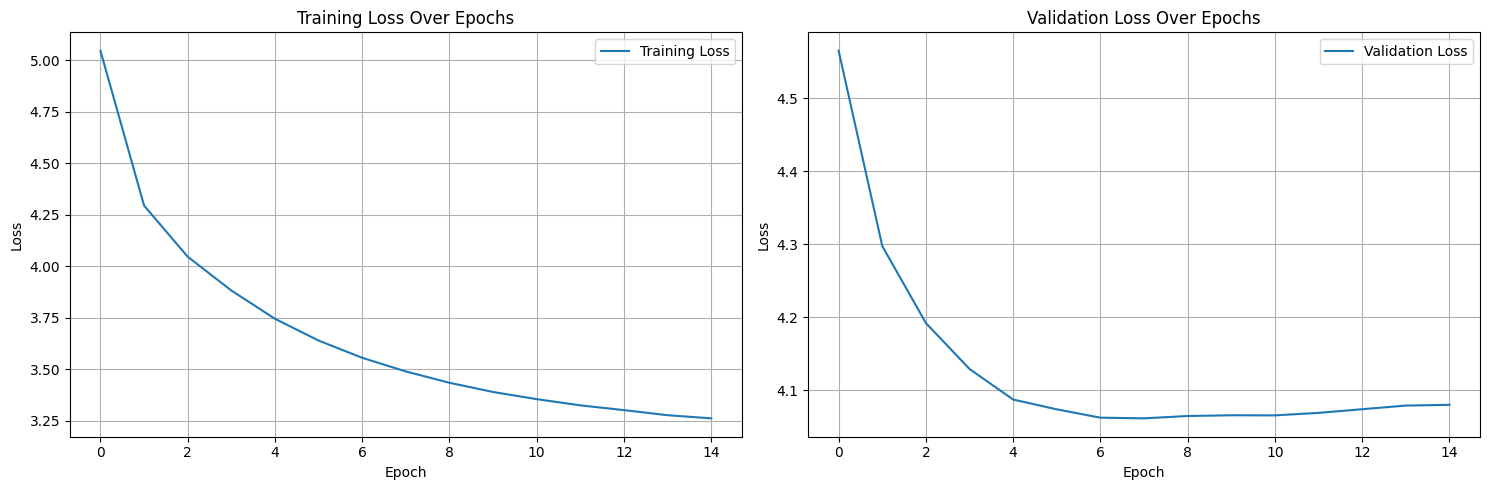

In [23]:
# Plot training history
plot_training_history(history)
    


In [27]:
# Print validation pairs and predictions
print("\nValidation Pairs vs Predictions:")
print("-" * 50)

evaluate_model(model, val_loader, device, dataset, BATCH_SIZE)
    



Validation Pairs vs Predictions:
--------------------------------------------------

Pair 1:
Context: ['##e', '##nt', 'visitors', 'to', 'ar', '##e', '##a', 'want']
True word: this
Predicted: ##e
Correct: ✗

Pair 2:
Context: ['do', '##e', '##s', '##n', 'a', '##d', '##d', 'valu']
True word: t
Predicted: ##e
Correct: ✗

Pair 3:
Context: ['i', 'am', 'f', '##r', '##e', 'to', 'b', '##e']
True word: ##e
Predicted: ##e
Correct: ✓

Pair 4:
Context: ['##e', 'you', 'f', '##e', '##l', 'a', 'bit', 'grumpy']
True word: ##e
Predicted: a
Correct: ✗

Pair 5:
Context: ['##e', '##ling', 'str', '##e', '##e', '##d', 'about', 'it']
True word: ##ss
Predicted: f
Correct: ✗

Pair 6:
Context: ['##e', '##d', 'by', 'th', '##m', '[PAD]', '[PAD]', '[PAD]']
True word: ##e
Predicted: ##e
Correct: ✓

Pair 7:
Context: ['passionat', '##e', 'about', 'it', 'know', 'this', 'i', '##s']
True word: and
Predicted: ##e
Correct: ✗

Pair 8:
Context: ['##e', '##d', 'folds', 'mor', 'than', 'i', 'am', '[PAD]']
True word: ##e
Predic

In [30]:
# Save final model and vocabulary
print("\nSaving final model and vocabulary...")

final_model_dir = 'final_model'
os.makedirs(final_model_dir, exist_ok=True)
    
# Save vocabulary
save_vocabulary(final_model_dir, dataset)
    
# Save final model state
save_model(final_model_dir, model, val_loss, accuracy)


Saving final model and vocabulary...


## Cosine Similarity Triplets Part

In [31]:
import torch

# Assuming we have a batch of indices for context words
context_indices = torch.randint(0, model.vocab_size, (10, 4))  # Example context indices
output = model(context_indices)

# Function to find triplets (two similar and one dissimilar)
def find_triplets(model: Word2VecModel, num_triplets: int = 2):
    triplets = []
    
    for i in range(num_triplets):
        # Randomly choose an initial word index
        word_idx = torch.randint(0, model.vocab_size, (1,)).item()
        
        # Find most similar words
        most_similar = model.find_most_similar(word_idx, top_k=2)
        
        # Find the least similar word
        least_similar = model.find_least_similar(word_idx)
        
        # Construct the triplet
        triplet = (word_idx, most_similar[0][0], most_similar[1][0], least_similar[0])
        triplets.append(triplet)
    
    return triplets

# Get the triplets using the trained model
triplets = find_triplets(model)

# Print the identified triplets
print("Identified Triplets:")
for triplet in triplets:
    print(f"Two similar tokens: ({triplet[0]}, {triplet[1]}) and ({triplet[0]}, {triplet[2]}), One dissimilar token: {triplet[3]}")
    sim1 = model.cosine_similarity(triplet[0], triplet[1])
    sim2 = model.cosine_similarity(triplet[0], triplet[2])
    sim3 = model.cosine_similarity(triplet[0], triplet[3])
    print(f"Cosine similarity between ({triplet[0]}, {triplet[1]}): {sim1}")
    print(f"Cosine similarity between ({triplet[0]}, {triplet[2]}): {sim2}")
    print(f"Cosine similarity between ({triplet[0]}, {triplet[3]}): {sim3}")


Identified Triplets:
Two similar tokens: (4334, 8422) and (4334, 2404), One dissimilar token: 1730
Cosine similarity between (4334, 8422): 0.920325517654419
Cosine similarity between (4334, 2404): 0.9192994236946106
Cosine similarity between (4334, 1730): -0.8801363706588745
Two similar tokens: (1791, 644) and (1791, 3454), One dissimilar token: 1885
Cosine similarity between (1791, 644): 0.9260221123695374
Cosine similarity between (1791, 3454): 0.9207223653793335
Cosine similarity between (1791, 1885): -0.8799864649772644
